# Introduction

## Why Cancer detection
Cancer is the second largest cause of death in the United States and it is estimated that about 1.9 million people are diagnosed every year in the United States

## How do we solve it
In this project we attempt to identify metastatic cancer in the images using Convolutional Neural Networks and test different architectures to determine which performs the best.

## Where did the data come from
The dataset comes from the https://www.kaggle.com/competitions/histopathologic-cancer-detection webpage which has a modified version of the PCam benchmark dataset that does not contain duplicate images

## Library imports and GPU setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print("CUDA Version:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN Version:", tf.sysconfig.get_build_info()["cudnn_version"])
print("Tensorflow Version: ", str(tf.__version__))
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print("Available GPUs: ", gpus)

# Check if TensorFlow can access the GPU
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is NOT using the GPU.")
;

2024-11-26 02:45:05.341116: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 02:45:05.374512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA Version: 12.3
cuDNN Version: 8
Tensorflow Version:  2.16.1
Num GPUs Available:  1
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using the GPU!


2024-11-26 02:45:06.685459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.691290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.691321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


''

In [3]:
if gpus:
    # Get memory info for the first GPU
    memory_info = tf.config.experimental.get_memory_info('GPU:0')
    print(f"Current memory usage: {memory_info['current']} bytes")
    print(f"Peak memory usage: {memory_info['peak']} bytes")
;

Current memory usage: 0 bytes
Peak memory usage: 0 bytes


2024-11-26 02:45:06.702896: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.702951: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.702964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.852475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-26 02:45:06.852510: I external/local_xla/xla/stream_executor

''

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow.keras.preprocessing.image as kpre
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import altair as alt

## Load the Data

In [ ]:
DATA_USED = 60000

This function is to create a new directory architecture that has the images in a folder with their label as the title. It is so that we can use tensorflow's generator functions to load in data (also pytorch uses a similar directory). Change cell type from Raw to code if running for the first time

We will be loading the data in from generators for efficiency and then transforming the generators into dataSets in order to cache and prefetch the data on training.

In [5]:
BATCH_SIZE = 32

dataGen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
testGen = ImageDataGenerator(rescale=1.0/255)
trainGen = dataGen.flow_from_directory(
    'Data/Train_with_labels_shrunk',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)
validationGen = dataGen.flow_from_directory(
    'Data/Train_with_labels_shrunk',
    target_size=(96, 96),
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)
testData = testGen.flow_from_directory(
    'Data/test2',
    target_size=(96,96),
    batch_size=1,
    shuffle=False
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: trainGen,
    output_types=(tf.float32, tf.int32),  # Adjust based on data type
    output_shapes=((None,96,96,3), (None,))
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: validationGen,
    output_types=(tf.float32, tf.int32),
    output_shapes = ((None,96,96,3), (None,))
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 48001 images belonging to 2 classes.
Found 11999 images belonging to 2 classes.
Found 57458 images belonging to 1 classes.


In [6]:
labels = pd.read_csv('Data/train_labels/train_labels.csv')


,label,count,Percentage
0,0,35767,0.596117
1,1,24233,0.403883


###  Perform basic EDA

In [7]:
# using 60000 because that is the amount of data that we moved to generators
# using sort_values by id because when we move the data into folders, it is selecting the first files from the train directory sorted by name
valueCounts = labels.sort_values(by=['id']).iloc[:DATA_USED]['label'].value_counts().reset_index() 
valueCounts['Percentage'] = valueCounts['count'] / valueCounts['count'].sum()
# valueCounts
alt.Chart(valueCounts).mark_bar().encode(
    x = 'label:O',
    y = alt.Y('Percentage:Q', scale=alt.Scale(domain=(0, 0.7))),
    tooltip='count'
).properties(
    title="Percentage of positive and negative values",
    width = 200)

alt.Chart(...)

2024-11-26 02:45:09.756826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


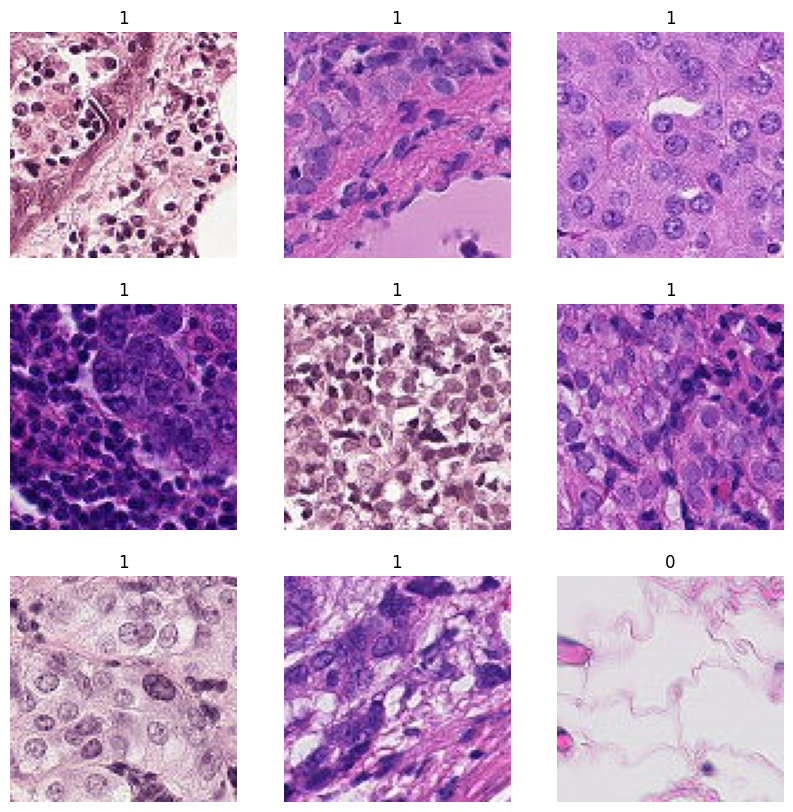

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow((images[i].numpy() * 255 ).astype("uint8"))
      plt.title(labels[i].numpy().astype("uint8"))
      plt.axis("off")

# Build The Models

First we will import some of the basic functions and variables we will use between each model.

We are setting the epochs value high and will use an early_stopping paramater to decide when the model has reached its best form. This paramater may change in models that take up more space on our GPU.

In [9]:
# Basic imports and variables used among most models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Add, Dropout, Dense, MaxPooling2D, Input, Concatenate, ReLU, LeakyReLU, Flatten, BatchNormalization
epochs = 200
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=20,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=15
)

## First lets use some prebuilt CNN architectures that are standard methods.

### First Model will be DenseNet.
From https://www.geeksforgeeks.org/densenet-explained/, DenseNet connects every layer of the network in a feed-forward manner. Each block is multiple convolution layers followed by a batch normalization and ReLU activation function. It also states that DenseNet is suited for medical imaging so we will be testing that here.

In [10]:
from tensorflow.keras.applications import DenseNet169
denseNet = DenseNet169(input_shape=(96,96,3), pooling = 'avg', classes = 2, weights = None)
x = denseNet.output
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
denseNetModel = tf.keras.models.Model(inputs = denseNet.input, outputs = predictions)

In [11]:
denseNetModel.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 102, 102,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 48, 48,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 48, 48,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 48, 48,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 50, 50,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 24, 24,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 24, 24,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 24, 24,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 24, 24,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 24, 24,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 24, 24,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 24, 24,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 24, 24,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 24, 24,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 24, 24,    │     12,288 │ conv2_block2_0_r

 Total params: 12,646,213 (48.24 MB)

 Trainable params: 12,487,813 (47.64 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [ ]:
# denseNetModel.summary()


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=5
)

denseNetModel.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
             callbacks=[early_stopping], steps_per_epoch=trainGen.samples // trainGen.batch_size,
          validation_steps=validationGen.samples // validationGen.batch_size)

Epoch 1/200


I0000 00:00:1732521830.065925   80941 service.cc:145] XLA service 0x7f71f0002740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732521830.065969   80941 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-25 08:03:51.510149: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 08:03:56.201493: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1732521839.863056   81140 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45205', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1732521839.933006   81141 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_45205', 296 bytes spill stores, 304 bytes spill loads

I0000 

1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - binary_accuracy: 0.6704 - loss: 0.5858

I0000 00:00:1732522073.168302   80943 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_multiply_rsqrt_fusion_2', 4 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_rsqrt_fusion_18', 988 bytes spill stores, 988 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_rsqrt_fusion_19', 1020 bytes spill stores, 1044 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_rsqrt_fusion_20', 904 bytes spill stores, 936 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_rsqrt_fusion_21', 620 bytes spill stores, 620 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_multiply_rsqrt_fusion_22', 588 bytes spill stores, 588 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'lo

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 315s 126ms/step - binary_accuracy: 0.6706 - loss: 0.5858 - val_binary_accuracy: 0.6921 - val_loss: 0.6457
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - binary_accuracy: 0.8290 - loss: 0.4391

I0000 00:00:1732522205.033154   81566 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4554', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732522205.089809   81554 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4554', 264 bytes spill stores, 272 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 134s 89ms/step - binary_accuracy: 0.8290 - loss: 0.4391 - val_binary_accuracy: 0.8168 - val_loss: 0.4254
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 119s 79ms/step - binary_accuracy: 0.8490 - loss: 0.3736 - val_binary_accuracy: 0.6932 - val_loss: 0.7817
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 121s 81ms/step - binary_accuracy: 0.8722 - loss: 0.3357 - val_binary_accuracy: 0.7656 - val_loss: 0.5665
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 119s 80ms/step - binary_accuracy: 0.8795 - loss: 0.3014 - val_binary_accuracy: 0.6647 - val_loss: 0.9053
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - binary_accuracy: 0.8918 - loss: 0.2852 - val_binary_accuracy: 0.8671 - val_loss: 0.3288
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - binary_accuracy: 0.9037 - loss: 0.2507 - val_binary_accuracy: 0.6909 - val_loss: 0.9895
Epoch 8/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 106s 70ms/step - binary_accuracy: 0.9098 - loss: 0.2467 - val_binary_accuracy: 0.

In [36]:
predictions = model.predict(testData, steps=57458, verbose=1)
predictions = np.round(predictions.reshape(57458,))
files = [s.replace(".tif", "") for s in os.listdir('Data/test2/test')]
submission = pd.DataFrame(zip(files, predictions), columns=['id', 'label'])
submission = submission.to_csv('DenseNet50V2.csv', index = False)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 490s 8ms/step


### Next we will use ResNet and see what our score is
from https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/, implements skip connections to help with vanishing/ exploding gradient problems. "The advantage of adding this type of skip connection is that if any layer hurt the performance of architecture then it will be skipped by regularization". 

In [37]:
from tensorflow.keras.applications import ResNet50V2
resNet = ResNet50V2(input_shape=(96,96,3), pooling= 'avg', classes=2, weights=None)
x = resNet.output
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
ResNetModel = tf.keras.models.Model(inputs = resNet.input, outputs = predictions)

In [42]:
ResNetModel.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
# ResNetModel.summary()

In [40]:
ResNetModel.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
             callbacks=[early_stopping], steps_per_epoch=trainGen.samples // trainGen.batch_size,
          validation_steps=validationGen.samples // validationGen.batch_size)

Epoch 1/200


I0000 00:00:1732328444.764998   32866 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_13830', 352 bytes spill stores, 352 bytes spill loads

I0000 00:00:1732328444.815613   32869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_13830', 52 bytes spill stores, 52 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - binary_accuracy: 0.7371 - loss: 0.5872

I0000 00:00:1732328577.309031   33120 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1493', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1732328577.367861   33114 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1493', 424 bytes spill stores, 348 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 165s 173ms/step - binary_accuracy: 0.7372 - loss: 0.5872 - val_binary_accuracy: 0.5995 - val_loss: 0.7462
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 112s 150ms/step - binary_accuracy: 0.7980 - loss: 0.4981 - val_binary_accuracy: 0.6022 - val_loss: 0.8204
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 110s 146ms/step - binary_accuracy: 0.8396 - loss: 0.4109 - val_binary_accuracy: 0.7449 - val_loss: 0.5925
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 142ms/step - binary_accuracy: 0.8554 - loss: 0.3646 - val_binary_accuracy: 0.6270 - val_loss: 0.8562
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 107s 143ms/step - binary_accuracy: 0.8676 - loss: 0.3429 - val_binary_accuracy: 0.6766 - val_loss: 0.7436
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 96s 128ms/step - binary_accuracy: 0.8815 - loss: 0.3135 - val_binary_accuracy: 0.5986 - val_loss: 0.9552
Epoch 7/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 106ms/step - binary_accuracy: 0.8910 - loss: 0.2799 - val_binary_accuracy: 0.8375 - va

## Our models
Now that we have 2 models trained as a benchmark, we can attempt to build our own model and see how it performs against the prebuilt ones.

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Add, Dropout, Dense, MaxPooling2D, Input, Concatenate, ReLU, LeakyReLU, Flatten, BatchNormalization, AveragePooling2D

### first lets start with a simple approach

In [11]:
simpleModelInput = Input(shape=(96,96,3))

hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(simpleModelInput)
hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)

shortcut = hiddenLayers
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])

shortcut = hiddenLayers
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])

hiddenLayers = Flatten()(hiddenLayers)
hiddenLayers = Dense(128, activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
simpleModelOutput = Dense(1, activation='sigmoid')(hiddenLayers)

simpleModel = Model(inputs = simpleModelInput, outputs= simpleModelOutput)
simpleModel.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                    optimizer=tf.keras.optimizers.Adam(), 
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

In [12]:
simpleModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 96, 96,    │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 96, 96,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 96,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 96, 96,    │     36,928 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 96, 96,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 96, 96,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96, 96,    │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │ 96)               │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 96, 96,    │    110,720 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 96, 96,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 96, 96,    │    147,584 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 96, 96,    │          0 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96, 96,    │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │ 224)              │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2064384)   │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 264,241,2… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 264,759,041 (1009.98 MB)

 Trainable params: 264,759,041 (1009.98 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=1
)

In [14]:
simpleModel.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
             callbacks=[early_stopping], steps_per_epoch=trainGen.samples // trainGen.batch_size,
          validation_steps=validationGen.samples // validationGen.batch_size)

Epoch 1/200


I0000 00:00:1732589122.833647    8562 service.cc:145] XLA service 0x7fe5e4007dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732589122.833710    8562 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-26 02:45:22.884777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-26 02:45:23.111941: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


   1/1500 ━━━━━━━━━━━━━━━━━━━━ 6:43:53 16s/step - binary_accuracy: 0.5625 - loss: 0.6993

I0000 00:00:1732589136.687747    8562 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - binary_accuracy: 0.7085 - loss: 1.2284

2024-11-26 02:49:47.674651: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 336s 213ms/step - binary_accuracy: 0.7087 - loss: 1.2271 - val_binary_accuracy: 0.7473 - val_loss: 0.5619
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 141s 94ms/step - binary_accuracy: 0.8054 - loss: 0.4469 - val_binary_accuracy: 0.7928 - val_loss: 0.4499
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 137s 91ms/step - binary_accuracy: 0.8130 - loss: 0.4245 - val_binary_accuracy: 0.7963 - val_loss: 0.4847
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 138s 92ms/step - binary_accuracy: 0.8612 - loss: 0.3233 - val_binary_accuracy: 0.8108 - val_loss: 0.4970
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 137s 91ms/step - binary_accuracy: 0.9016 - loss: 0.2352 - val_binary_accuracy: 0.8106 - val_loss: 0.5667
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 136s 91ms/step - binary_accuracy: 0.9333 - loss: 0.1710 - val_binary_accuracy: 0.8078 - val_loss: 0.5260
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 139s 93ms/step - binary_accuracy: 0.9537 - loss: 0.1232 - val_binary_accuracy: 0

We can see from the history that this model does well with learning the features but does not generalize great to the validation data and stagnates at about 80% accuracy. To improve generability and reduce model size, we can add in pooling layers.

In [16]:
from tensorflow.keras.layers import GlobalAveragePooling2D

simpleModel2Input = Input(shape=(96,96,3))

hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(simpleModel2Input)
hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(32, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = AveragePooling2D(2, padding='same')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)

shortcut = hiddenLayers
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(64, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])
hiddenLayers = AveragePooling2D(2, padding='same')(hiddenLayers)

shortcut = hiddenLayers
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Conv2D(128, 3, padding='same', activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
hiddenLayers = Concatenate()([hiddenLayers, shortcut])


hiddenLayers = GlobalAveragePooling2D()(hiddenLayers)

hiddenLayers = Flatten()(hiddenLayers)
hiddenLayers = Dense(128, activation='relu')(hiddenLayers)
hiddenLayers = Dropout(0.3)(hiddenLayers)
simpleModel2Output = Dense(1, activation='sigmoid')(hiddenLayers)

simpleModel2 = Model(inputs = simpleModel2Input, outputs= simpleModel2Output)
simpleModel2.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                    optimizer=tf.keras.optimizers.Adam(), 
                   metrics=[tf.keras.metrics.BinaryAccuracy()])

In [17]:
simpleModel2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 96, 96,    │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 96, 96,    │      9,248 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 96, 96,    │      9,248 │ conv2d_16[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 48, 48,    │          0 │ conv2d_17[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 48, 48,    │          0 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 48, 48,    │     18,496 │ dropout_6[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 48, 48,    │     36,928 │ conv2d_18[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 48, 48,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 48, 48,    │          0 │ conv2d_20[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 48, 48,    │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │ 96)               │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 24, 24,    │          0 │ concatenate_3[0]… │
│ (AveragePooling2D)  │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 24, 24,    │    110,720 │ average_pooling2… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 24, 24,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 24, 24,    │    147,584 │ conv2d_22[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 24,    │          0 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 24, 24,    │          0 │ dropout_8[0][0],

 Total params: 546,561 (2.08 MB)

 Trainable params: 546,561 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',  # Metric to monitor for improvement
    patience=10,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore model weights to the best epoch
    start_from_epoch=1
)
simpleModel2History = simpleModel2.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
             callbacks=[early_stopping], steps_per_epoch=trainGen.samples // trainGen.batch_size,
          validation_steps=validationGen.samples // validationGen.batch_size)

Epoch 1/200


I0000 00:00:1732593991.629282   10384 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1844', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1732593991.741111   10385 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3126', 24 bytes spill stores, 24 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 329s 213ms/step - binary_accuracy: 0.7293 - loss: 0.5323 - val_binary_accuracy: 0.7889 - val_loss: 0.4577
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 124s 82ms/step - binary_accuracy: 0.8104 - loss: 0.4284 - val_binary_accuracy: 0.8238 - val_loss: 0.4060
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 115s 77ms/step - binary_accuracy: 0.8327 - loss: 0.3912 - val_binary_accuracy: 0.8446 - val_loss: 0.3578
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 125s 83ms/step - binary_accuracy: 0.8463 - loss: 0.3565 - val_binary_accuracy: 0.8657 - val_loss: 0.3160
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 118s 79ms/step - binary_accuracy: 0.8616 - loss: 0.3247 - val_binary_accuracy: 0.8696 - val_loss: 0.3090
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 108s 72ms/step - binary_accuracy: 0.8735 - loss: 0.3056 - val_binary_accuracy: 0.8655 - val_loss: 0.3176
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 98s 65ms/step - binary_accuracy: 0.8797 - loss: 0.2849 - val_binary_accuracy: 0.

We can see that from adding the pooling layers, we have improved generability, reduced network size, and increased the validation accuracy to about 93%.

In [20]:
predictions = simpleModel2.predict(testData, steps=57458, verbose=1)
predictions = np.round(predictions.reshape(57458,))
files = [s.replace(".tif", "") for s in os.listdir('Data/test2/test')]
submission = pd.DataFrame(zip(files, predictions), columns=['id', 'label'])
submission = submission.to_csv('SimpleModel2.csv', index = False)

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 510s 9ms/step


We can see from this Model that it does not do well to generalize and ends up overfitting.

# attempting model from white paper with circular initial weights

In [16]:


class CircleFilterLayer(tf.keras.layers.Layer):
    """
    Circle Filters Layer (CF)
    Custom convolutional layer with circularly initialized filters.
    """
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', **kwargs):
        super(CircleFilterLayer, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.conv = None  # Will be initialized in build()

    def build(self, input_shape):
        # Create a convolutional layer
        self.conv = tf.keras.layers.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=True,
            kernel_initializer=self._circle_initializer()
        )

    def _circle_initializer(self):
        """
        Custom initializer that sets weights to a circular pattern.
        """
        def initializer(shape, dtype=None):
            weights = np.zeros(shape, dtype=np.float32)
            center = (shape[0] // 2, shape[1] // 2)
            for i in range(shape[0]):  # Height of the kernel
                for j in range(shape[1]):  # Width of the kernel
                    distance = ((i - center[0])**2 + (j - center[1])**2)**0.5
                    weights[i, j, :, :] = np.exp(-distance)  # Gaussian radial decay
            return tf.convert_to_tensor(weights, dtype=dtype)

        return initializer

    def call(self, inputs):
        return self.conv(inputs)



In [20]:
def circleResidual(x, filters):
    shortcut = x
    y = Dropout(0.2)(x)
    y = CircleFilterLayer(filters = filters, kernel_size=(3,3))(y)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Dropout(0.2)(y)
    y = Conv2D(filters, 3, padding = 'same')(y)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    y = Add()([y, shortcut])
    return y

In [24]:
circleInput = Input(shape = (96,96,3))

x = CircleFilterLayer(filters = 64, kernel_size=(3,3))(circleInput)
for i in range(3):
    x = circleResidual(x, 64)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
circleOutput = Dense(1, activation='sigmoid')(x)
circleModel = Model(inputs = circleInput, outputs = circleOutput)


In [25]:
circleModel.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [26]:
circleModelHistory = circleModel.fit(train_dataset, validation_data=validation_dataset,
                                epochs=epochs, callbacks=[early_stopping],
                               steps_per_epoch=trainGen.samples // trainGen.batch_size,
                                validation_steps=validationGen.samples // validationGen.batch_size)

Epoch 1/200
 737/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 71ms/step - binary_accuracy: 0.5476 - loss: 75.2313

I0000 00:00:1732497379.586345   57589 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 8 bytes spill stores, 8 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 132s 82ms/step - binary_accuracy: 0.5571 - loss: 44.0544 - val_binary_accuracy: 0.5946 - val_loss: 0.6302
Epoch 2/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 117s 78ms/step - binary_accuracy: 0.5976 - loss: 0.6305 - val_binary_accuracy: 0.5887 - val_loss: 0.6311
Epoch 3/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 117s 78ms/step - binary_accuracy: 0.6007 - loss: 0.6283 - val_binary_accuracy: 0.6030 - val_loss: 0.6768
Epoch 4/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 114s 76ms/step - binary_accuracy: 0.5926 - loss: 0.6770 - val_binary_accuracy: 0.5966 - val_loss: 0.6743
Epoch 5/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 112s 75ms/step - binary_accuracy: 0.5983 - loss: 0.6724 - val_binary_accuracy: 0.5938 - val_loss: 0.6754
Epoch 6/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 109s 73ms/step - binary_accuracy: 0.5977 - loss: 0.6741 - val_binary_accuracy: 0.5969 - val_loss: 0.6743
Epoch 7/200
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 100s 67ms/step - binary_accuracy: 0.5978 - loss: 0.6740 - val_binary_accuracy: 0

# Results and Analysis

# Discussion and Conclusions
